In [1]:
import yfinance as yf 
import pandas as pd
import requests
import numpy as np
import seaborn as sns

import warnings
from functools import reduce
from scipy.cluster.hierarchy import dendrogram, linkage 
from scipy.cluster.hierarchy import fcluster 
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist 
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd

from pylab import rcParams 
import sklearn
from sklearn.cluster import AgglomerativeClustering 
import sklearn.metrics as sm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
warnings.filterwarnings('ignore')


In [2]:
companies_df = pd.read_csv('constituents.csv')
ticker_symbols = companies_df['Symbol'].tolist()

start_date = '2023-01-01'
end_date ='2024-01-01'

fortune500_df = pd.read_csv('fortune500.csv')
fortune500_df = (fortune500_df.groupby('Name')
                              .size()
                              .to_frame('No. Years in 500 Forbes')
                              .reset_index())

companies_in_fortune_500 = fortune500_df['Name'].unique()

companies_in_fortune_500_df = companies_df[companies_df['Security'].isin(companies_in_fortune_500)]
companies_in_fortune_500_df = pd.merge(fortune500_df, companies_in_fortune_500_df,
                                        how='inner', 
                                        left_on = 'Name',
                                        right_on = 'Security')
companies_in_fortune_500_df = companies_in_fortune_500_df.rename(columns = {'Symbol': 'symbol'})

symbols_500_fortune = companies_in_fortune_500_df['symbol'].to_list()

balance_sheet = pd.read_csv('Q_balance_sheet.csv')
balance_sheet['fiscalDateEnding'] = pd.to_datetime(balance_sheet['fiscalDateEnding'])
balance_sheet.set_index('fiscalDateEnding', inplace=True)

bs_500_fortune = balance_sheet[balance_sheet['symbol'].isin(symbols_500_fortune)]

bs = bs_500_fortune[(bs_500_fortune.index >= start_date) 
                    & (bs_500_fortune.index <= end_date)]
bs.index = pd.to_datetime(bs.index).to_period('M')


income_statement_500_fortune_dfs =[]
for symbol in symbols_500_fortune:
  ticker = yf.Ticker(symbol)
  metrics = ['Gross Profit', 
             'Net Income',
             'Total Revenue', 
             'Research And Development',
             'Operating Income', 
             'Operating Expense',
             'Selling General And Administration', 
             'Selling And Marketing Expense',
             'General And Administrative Expense', 
             'Cost Of Revenue', 
             'Operating Revenue']
  
  income_statement_500_fortune_df = ticker.quarterly_financials.T
  avail_metrics = [metric for metric in metrics 
                              if metric in income_statement_500_fortune_df.columns]
  income_statement_500_fortune_df = income_statement_500_fortune_df[avail_metrics]
  income_statement_500_fortune_df['symbol'] = symbol
  income_statement_500_fortune_dfs.append(income_statement_500_fortune_df)

income_statement_500_fortune_dfs = pd.concat(income_statement_500_fortune_dfs, axis = 0)
inc_st = income_statement_500_fortune_dfs[(income_statement_500_fortune_dfs.index >= start_date) 
                                          & (income_statement_500_fortune_dfs.index <= end_date)]
inc_st.index = pd.to_datetime(inc_st.index).to_period('M')

companies_in_fortune_500_df

,Name,No. Years in 500 Forbes,symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,3M,67,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AT&T,61,T,AT&T,Communication Services,Integrated Telecommunication Services,"Dallas, Texas",1983-11-30,732717,1983 (1885)
2,AbbVie,8,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,Aflac,1,AFL,Aflac,Financials,Life & Health Insurance,"Columbus, Georgia",1999-05-28,4977,1955
4,Agilent Technologies,14,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,"Santa Clara, California",2000-06-05,1090872,1999
...,...,...,...,...,...,...,...,...,...,...
207,Weyerhaeuser,67,WY,Weyerhaeuser,Real Estate,Timber REITs,"Seattle, Washington",1979-10-01,106535,1900
208,Wynn Resorts,7,WYNN,Wynn Resorts,Consumer Discretionary,Casinos & Gaming,"Paradise, Nevada",2008-11-14,1174922,2002
209,Xcel Energy,25,XEL,Xcel Energy,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909
210,Zoetis,3,ZTS,Zoetis,Health Care,Pharmaceuticals,"Parsippany, New Jersey",2013-06-21,1555280,1952


In [3]:
pricing_df = yf.download(tickers = symbols_500_fortune, 
                         start=start_date, 
                         end=end_date)
pricing_df = (pricing_df.stack()
                        .reset_index(level = 1))
pricing_df = (pricing_df.groupby('Ticker')
                        .apply(lambda group: group.sort_index())
                        .reset_index(level = 0, drop=True))
daily_returns = (pricing_df.groupby('Ticker')
                     .apply(lambda group: group.sort_index()['Adj Close']
                     .pct_change()*100
                      )).T
daily_returns


[*********************100%***********************]  212 of 212 completed


Ticker,A,AAL,ABBV,ADI,AEE,AEP,AFL,AIZ,ALL,AMAT,...,VZ,WDC,WEC,WFC,WM,WMT,WY,WYNN,XEL,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-04 00:00:00+00:00,1.086388,6.671903,0.806738,2.129906,0.531145,0.685136,0.474982,1.390187,1.683029,2.667211,...,2.517455,5.221265,0.658457,2.057915,-0.076411,0.111404,1.198958,6.179173,0.856301,1.436844
2023-01-05 00:00:00+00:00,0.290099,2.943338,-0.122182,-3.749014,-3.327336,-1.821603,-0.583971,-2.269723,0.273457,-1.399654,...,1.385847,6.596068,-2.500533,-0.539281,-1.931046,-0.340826,-2.977917,0.484052,-2.023502,-2.356344
2023-01-06 00:00:00+00:00,-2.918940,1.358117,1.871678,3.650815,2.697670,2.932391,3.272712,1.926117,1.456867,6.484883,...,1.175057,5.506667,2.553832,0.895807,3.645709,2.449913,4.323442,2.441439,2.960727,1.505668
2023-01-09 00:00:00+00:00,-0.135443,3.032435,-2.936041,0.954581,1.234155,1.471055,-3.236725,-2.706274,-0.962038,2.129092,...,-0.402060,1.129949,1.888789,-0.957946,-0.783756,-1.246758,-0.601084,0.812226,0.967879,-0.392845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22 00:00:00+00:00,0.453423,-0.278745,1.540077,0.417774,-0.041610,0.424790,0.295534,0.460108,1.477101,0.408942,...,0.160308,0.534553,0.716459,-0.546009,0.079176,1.195093,0.732923,-0.330693,0.861368,0.164381
2023-12-26 00:00:00+00:00,0.171950,-1.397629,-0.206526,0.898019,-0.416277,0.435437,0.331490,0.222964,0.494924,1.376119,...,-0.026695,0.189895,0.843970,0.935347,0.322126,-0.153215,0.785792,0.641452,0.306156,0.266698
2023-12-27 00:00:00+00:00,0.007164,-0.850460,0.168147,0.241366,-0.097530,0.099080,0.232508,0.036076,0.224492,-0.042604,...,-0.453558,-0.644428,-0.227166,-0.624494,0.129562,0.939850,0.375387,-0.406591,-0.307796,0.716106


In [4]:
#compute quarterly volatility
daily_vol = daily_returns.std()
annualized_vol = daily_vol * np.sqrt(252)
quarterly_vol = annualized_vol * np.sqrt(1/4)
quarterly_vol_df = quarterly_vol.reset_index().rename(columns = {'Ticker':'symbol', 0:'Quarterly Volatility'})
quarterly_vol_df

,symbol,Quarterly Volatility
0,A,13.418168
1,AAL,17.637314
2,ABBV,9.807668
3,ADI,13.088020
4,AEE,10.993934
...,...,...
207,WMT,7.813083
208,WY,11.950559
209,WYNN,15.250763
210,XEL,9.864231


In [5]:
pd.set_option('display.max_columns', None)

fin_st = pd.merge(inc_st.reset_index(), bs.reset_index(), how='inner', left_on=['symbol','index'], right_on=['symbol', 'fiscalDateEnding']).set_index('index')
fin_st = fin_st.drop_duplicates(keep='first')

In [6]:
#Profitability
profitability_df = pd.DataFrame()

profitability_df['symbol'] = fin_st['symbol']


profitability_df['Net Profit Margin (%)'] = np.where(~fin_st['Total Revenue'].isnull() 
                                                     & (fin_st['Total Revenue'] != 0)
                                                     & (~fin_st['Net Income'].isnull()),(fin_st['Net Income']/
                                                       fin_st['Total Revenue']*100).round(2),0)

profitability_df['Operating Profit Margin (%)'] = np.where(~fin_st['Total Revenue'].isnull()
                                                       & (fin_st['Total Revenue'] != 0)
                                                       & (~fin_st['Operating Income'].isnull()),(fin_st['Operating Income']/
                                                        fin_st['Total Revenue']*100).round(2),0)

profitability_df = (profitability_df.groupby('symbol')
                                    .agg({
                                    'Net Profit Margin (%)': 'mean',
                                    'Operating Profit Margin (%)': 'mean'
                                    })
                                    .reset_index())
profitability_df

,symbol,Net Profit Margin (%),Operating Profit Margin (%)
0,A,17.455795,18.143837
1,AAL,1.405694,6.466401
2,ABBV,8.278082,18.93355
3,ADI,11.713858,14.632502
4,AEE,15.72103,25.888086
...,...,...,...
205,WMT,1.565567,3.120088
206,WY,8.92056,11.533657
207,WYNN,9.807683,12.972113
208,XEL,13.108816,19.524321


In [7]:
#Efficiency  

#average of quarterly asset turnover ratio over 4 most recent quarters period
#Average total assets are found by taking the average of the beginning and ending assets of the period being analyzed.
def average_total_assets(group):
    group = group[~group['totalAssets'].isnull()]
    start_assets = group.loc[group.index.min(), 'totalAssets']
    end_assets = group.loc[group.index.max(), 'totalAssets']
    avg = (start_assets + end_assets) / 2
    return avg
avg_total_assets = fin_st.groupby('symbol').apply(average_total_assets).reset_index(name='Average Total Asset')

def total_revenue(group):
    return group['Total Revenue'].sum()

total_revenue = fin_st.groupby('symbol').apply(total_revenue).reset_index(name='Total Revenue')

efficiency_df = pd.merge(avg_total_assets, total_revenue, on = 'symbol', how='inner' )
efficiency_df

,symbol,Average Total Asset,Total Revenue
0,A,1.077750e+10,5.077000e+09
1,AAL,6.492200e+10,4.059900e+10
2,ABBV,1.346275e+11,4.209300e+10
3,ADI,4.951450e+10,5.792979e+09
4,AEE,3.988850e+10,5.438000e+09
...,...,...,...
205,WMT,2.511855e+11,4.747370e+11
206,WY,1.678150e+10,5.793000e+09
207,WYNN,1.386012e+10,5.108218e+09
208,XEL,6.286850e+10,1.012600e+10


In [8]:

#Liquidity: The ability to repay debts with availabel, generated capital 
#Current Ratio
liquidity_df=pd.DataFrame()
liquidity_df['symbol'] = fin_st['symbol']
liquidity_df['Current Ratio'] = fin_st['totalCurrentAssets']/fin_st['totalCurrentLiabilities']
liquidity_df = liquidity_df.groupby('symbol')['Current Ratio'].mean().round(2).reset_index()
liquidity_df


,symbol,Current Ratio
0,A,2.42
1,AAL,0.69
2,ABBV,0.92
3,ADI,1.75
4,AEE,0.60
...,...,...
205,WMT,0.83
206,WY,1.93
207,WYNN,2.73
208,XEL,0.80


In [9]:
fin_metric_dfs = [quarterly_vol_df, profitability_df, efficiency_df, liquidity_df, companies_in_fortune_500_df[['No. Years in 500 Forbes','symbol']]]
merged_df = reduce(lambda left, right: pd.merge(left, right, on = 'symbol'), fin_metric_dfs)
merged_df

,symbol,Quarterly Volatility,Net Profit Margin (%),Operating Profit Margin (%),Average Total Asset,Total Revenue,Current Ratio,No. Years in 500 Forbes
0,A,13.418168,17.455795,18.143837,1.077750e+10,5.077000e+09,2.42,14
1,AAL,17.637314,1.405694,6.466401,6.492200e+10,4.059900e+10,0.69,8
2,ABBV,9.807668,8.278082,18.93355,1.346275e+11,4.209300e+10,0.92,8
3,ADI,13.088020,11.713858,14.632502,4.951450e+10,5.792979e+09,1.75,5
4,AEE,10.993934,15.72103,25.888086,3.988850e+10,5.438000e+09,0.60,24
...,...,...,...,...,...,...,...,...
205,WMT,7.813083,1.565567,3.120088,2.511855e+11,4.747370e+11,0.83,27
206,WY,11.950559,8.92056,11.533657,1.678150e+10,5.793000e+09,1.93,67
207,WYNN,15.250763,9.807683,12.972113,1.386012e+10,5.108218e+09,2.73,7
208,XEL,9.864231,13.108816,19.524321,6.286850e+10,1.012600e+10,0.80,25


In [14]:
merged_df_log = merged_df.copy()
columns_to_log = ['Average Total Asset', 'Total Revenue', 'Current Ratio', 'No. Years in 500 Forbes']
merged_df_log[columns_to_log] = merged_df_log[columns_to_log].apply(lambda x: np.log(x.replace(0, 1e-10)))

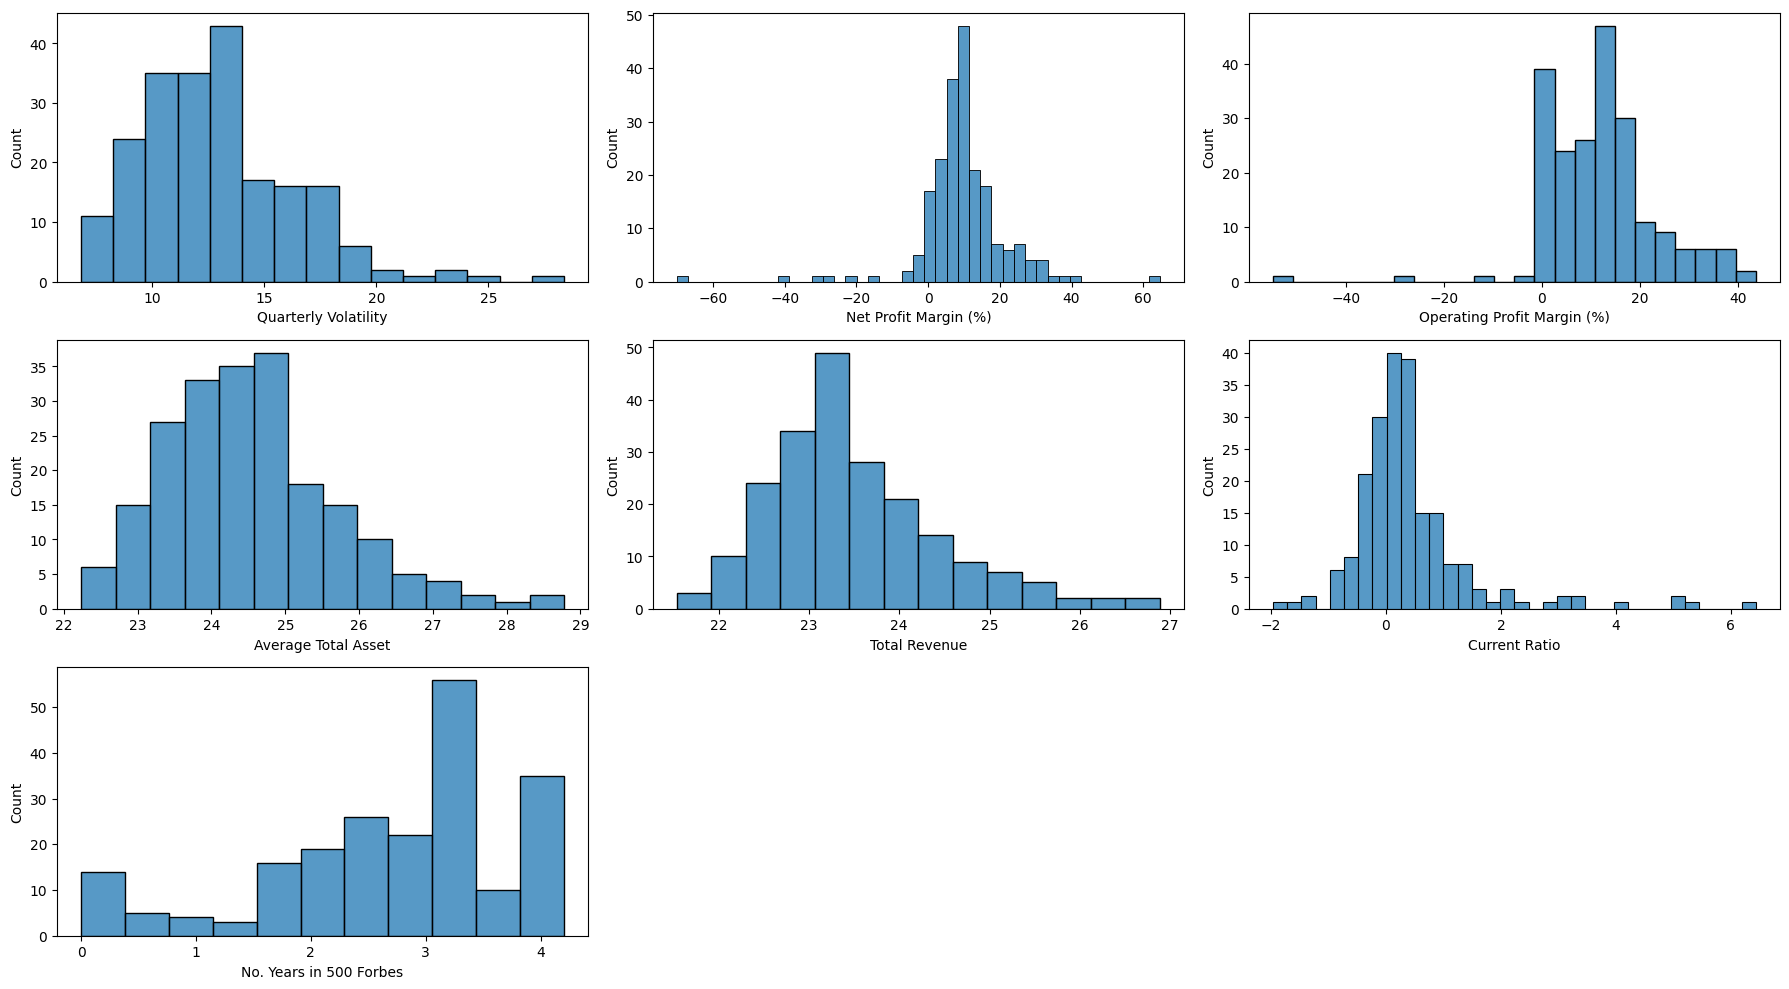

In [15]:
fig, axes = plt.subplots(3,3,figsize=(18,10))
axes = axes.flatten()
for i, col in enumerate(merged_df.drop(columns = ['symbol']).columns):
  sns.histplot(data=merged_df_log, x=col , ax = axes[i])
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()


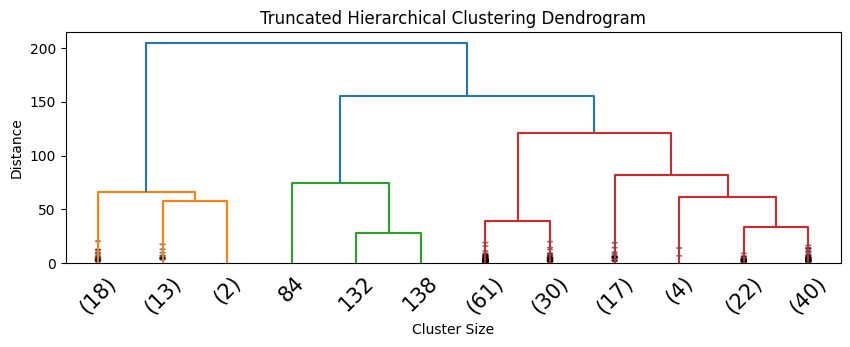

In [12]:
# Assuming merged_df is already defined
df_numeric = merged_df_log.drop(columns=['symbol'])
# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

np.set_printoptions(precision=4, suppress=True)
plt.figure(figsize=(10,3))
%matplotlib inline 
z = linkage(merged_df_log.drop(columns='symbol'), 'ward')
dendrogram(z, truncate_mode= 'lastp', p=12, leaf_rotation=45, leaf_font_size=15, show_contracted=True)
plt.title('Truncated Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=500)
plt.axhline(y=500)
plt.show()

Number of clusters: 5


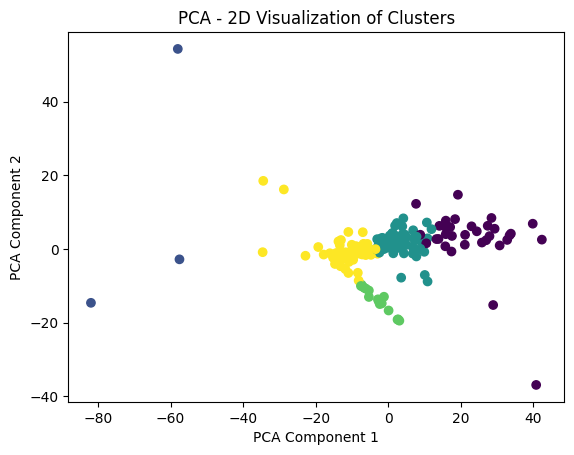

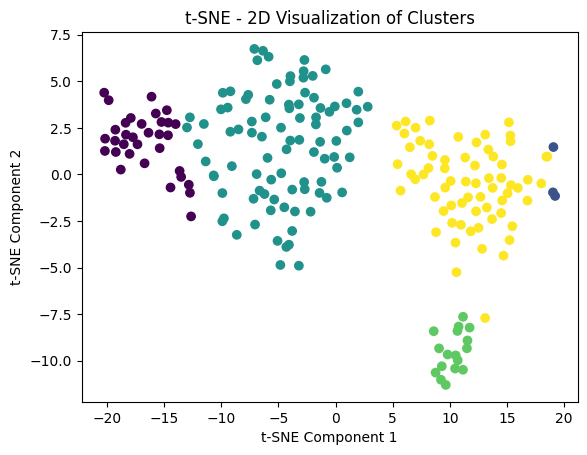

In [13]:
max_d = 80 
clusters = fcluster(z, max_d, criterion='distance')
print(f"Number of clusters: {len(set(clusters))}")
merged_df_log['Cluster'] = clusters

# Reduce to 2 dimensions
pca = PCA(n_components=2)
components = pca.fit_transform(merged_df_log.drop(columns=['symbol']))
plt.scatter(components[:, 0], components[:, 1], c=merged_df_log['Cluster'])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA - 2D Visualization of Clusters')
plt.show()

# Reduce to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(merged_df_log.drop(columns=['symbol']))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=merged_df_log['Cluster'])
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE - 2D Visualization of Clusters')
plt.show()